# 2. IMPORT LIBRARIES AND DATASET

In [1]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# Specify training data directory
X_Ray_Directory = '/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/train'

In [3]:
# List the folders in the directory
os.listdir(X_Ray_Directory)

['Tuberculosis',
 'Bacterial Pneumonia',
 'Corona Virus Disease',
 'Normal',
 'Viral Pneumonia']

In [4]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [5]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size= 40, directory = X_Ray_Directory, shuffle = True, target_size =(256,256), class_mode = 'categorical', subset = 'training')


Found 4845 images belonging to 5 classes.


In [6]:
validation_generator = image_generator.flow_from_directory(batch_size= 16, directory = X_Ray_Directory, shuffle = True, target_size =(256,256), class_mode = 'categorical', subset = 'validation')

Found 1209 images belonging to 5 classes.


In [7]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
train_labels.shape

(40, 5)

In [10]:
train_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0.

In [11]:
# labels Translator 
label_names = { 0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia', 4: 'Tuberculosis'}

# 3. VISUALIZE DATASET

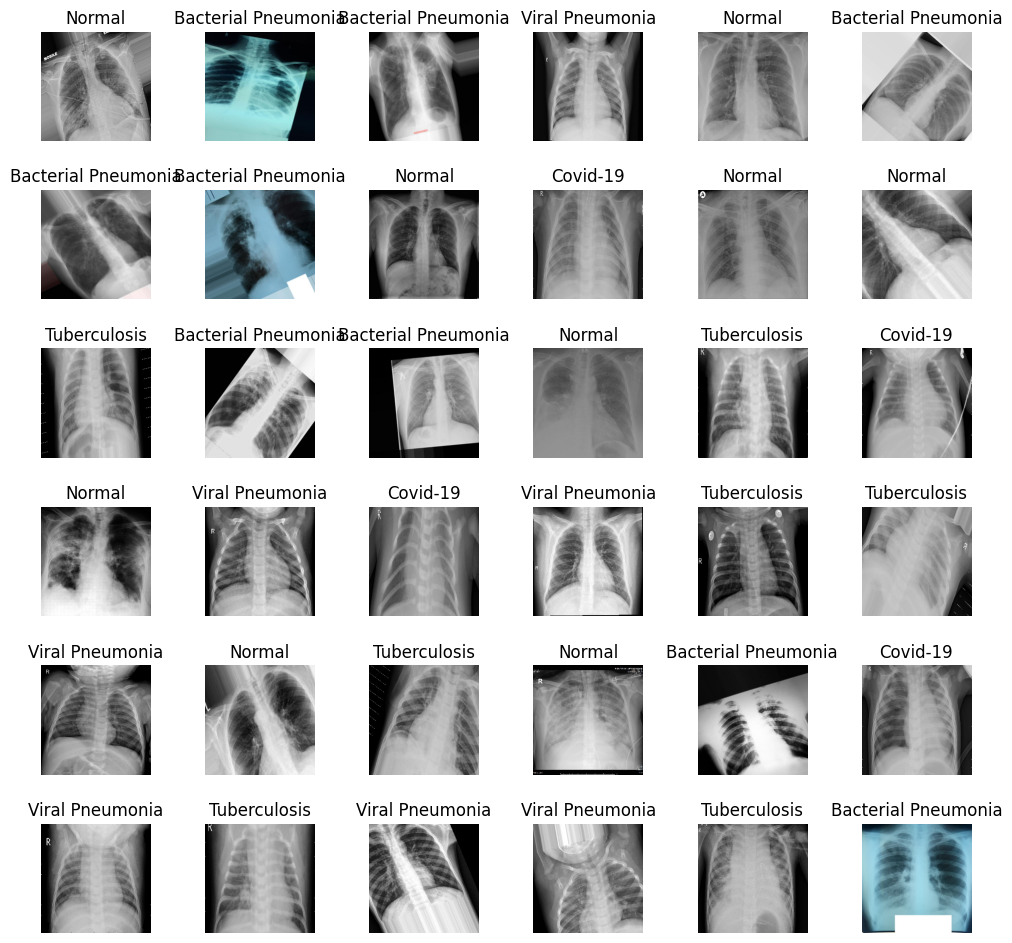

In [12]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# 4. IMPORT MODEL WITH PRETRAINED WEIGHTS

In [13]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
  layers.trainable = False

# 5. BUILD AND TRAIN DEEP LEARNING MODEL

In [16]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten (name = 'flatten') (headmodel)
headmodel = Dense(256, activation = 'relu') (headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu') (headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(5, activation = 'softmax') (headmodel)

In [17]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [18]:
from tensorflow.keras import optimizers

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

In [19]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = 'weights.keras', verbose = 1, save_best_only=True)

In [20]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'training')
validation_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'validation')

Found 4845 images belonging to 5 classes.
Found 1209 images belonging to 5 classes.


In [21]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpointer, earlystopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1212/1212 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6674 - loss: 0.9021
Epoch 1: val_loss improved from inf to 0.34222, saving model to weights.keras
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 158s 94ms/step - accuracy: 0.6674 - loss: 0.9019 - val_accuracy: 0.8354 - val_loss: 0.3422
Epoch 2/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8281 - loss: 0.4610
Epoch 2: val_loss did not improve from 0.34222
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 89s 73ms/step - accuracy: 0.8281 - loss: 0.4610 - val_accuracy: 0.8222 - val_loss: 0.4315
Epoch 3/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8617 - loss: 0.3999
Epoch 3: val_loss did not improve from 0.34222
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 90s 74ms/step - accuracy: 0.8617 - loss: 0.3999 - val_accuracy: 0.7709 - val_loss: 0.6376
Epoch 4/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8946 - loss: 0.3108
Epoch 4: val_loss did not improve from 0.34222
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 89s 73ms/step - accuracy: 0.8946 - loss: 

# 6. EVALUATE TRAINED DEEP LEARNING MODEL

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0, 0.5, 'Training Accuracy and Loss')

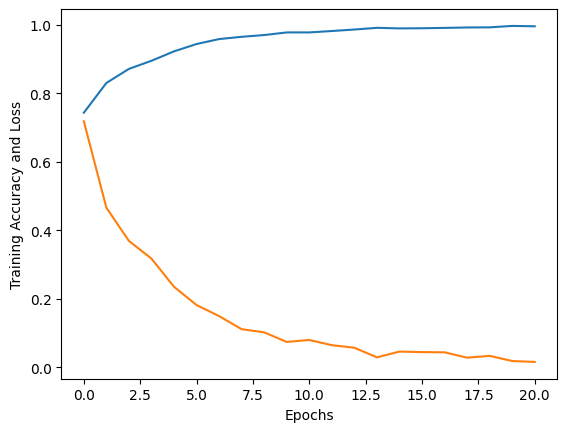

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy and Loss')

Text(0, 0.5, 'Validation Loss')

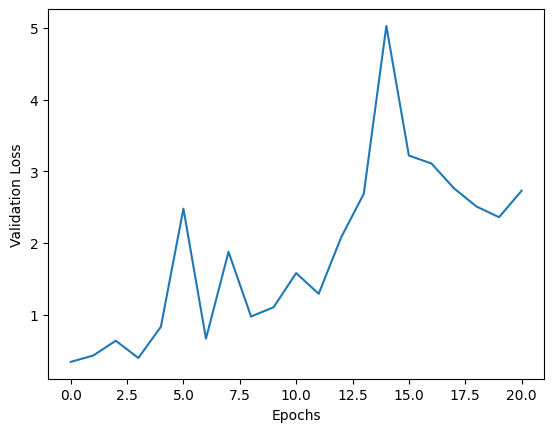

In [24]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Accuracy')

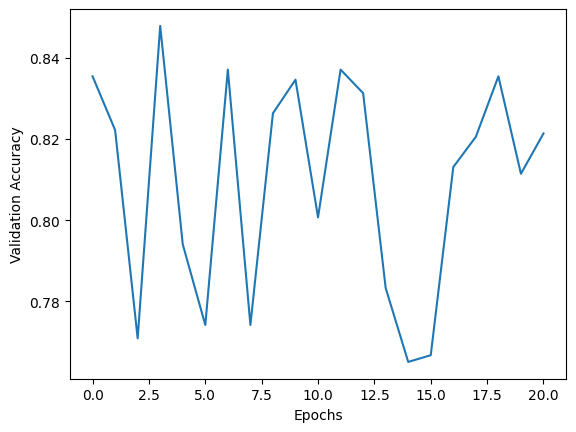

In [25]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [33]:
evaluate = model.evaluate(
    test_generator,
    steps=test_generator.n // 4,
    verbose=1
)
print('Accuracy Test: {:.2f}%'.format(evaluate[1] * 100))

506/506 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8647 - loss: 2.0358  
Accuracy Test: 86.57%


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
import os
import numpy as np

test_directory = '/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/test'

prediction = []
original = []
image = []

class_names = sorted(os.listdir(test_directory))  # ['Bacterial Pneumonia', 'COVID', ...]
label_map = {name: idx for idx, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(test_directory, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip unreadable files
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img_input = img / 255.0
        img_input = img_input.reshape(1, 256, 256, 3)
        pred = model.predict(img_input, verbose =0)
        pred_class = np.argmax(pred)
        prediction.append(pred_class)
        original.append(label_map[class_name])


In [41]:
len(original)

2025

In [42]:
score = accuracy_score(original, prediction)
print('Test Accuracy: {}'.format(score))

Test Accuracy: 0.8449382716049383


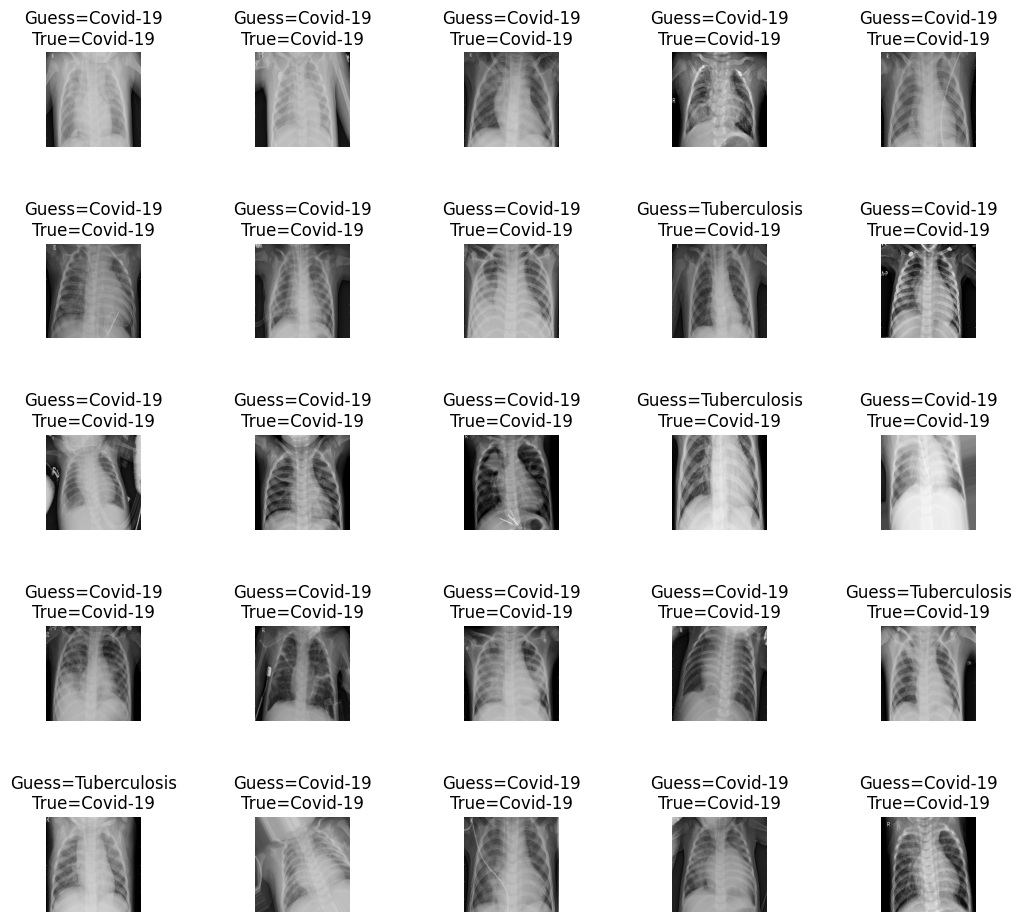

In [43]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [44]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.78      0.63      0.69       403
           1       0.99      0.91      0.95       407
           2       0.86      0.98      0.92       404
           3       0.91      1.00      0.95       408
           4       0.68      0.70      0.69       403

    accuracy                           0.84      2025
   macro avg       0.84      0.84      0.84      2025
weighted avg       0.84      0.84      0.84      2025



Text(0.5, 1.0, 'Confusion_matrix')

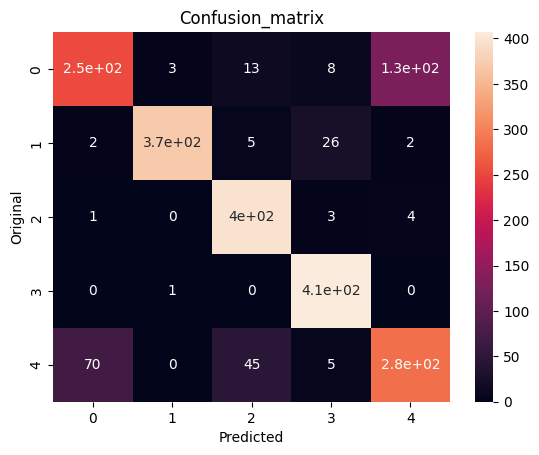

In [45]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')